Effect of Packet length to the spectrum

In [39]:
import numpy as np
import numpy.typing as npt
import math
import matplotlib.pyplot as plt
from examples.seismic import Receiver, WaveletSource, RickerSource, Model, TimeAxis,  plot_velocity, plot_shotrecord
from devito import TimeFunction, Eq, solve, Operator, ConditionalDimension
from scipy.signal import find_peaks, peak_prominences

from scipy.fft import fft, fftfreq

plt.rcParams['figure.figsize'] = (10, 10)  # Increases figure size

In [89]:
nx = 601
nz = 301
nb = 10
v_water = 1.5 # v in distilled water 1496.7 m/s
v_glass = 5.64 # v in glass 5640 m/s
glass = 5
f0 = 500  # Source peak frequency is 5 MHz (5000 kHz) [kHz]
shape = (nx, nz)
spatial_dist = round(v_water / f0 / 3, 3)
spacing = (spatial_dist, spatial_dist)
origin = (0., 0.)
# Define a velocity profile. The velocity is in km/s
v = np.empty(shape, dtype=np.float32)
v[:, :] = v_water 
v[:, -glass:] = v_glass
v[:glass, :] = v_glass
v[-glass:, :] = v_glass

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=nb, bcs="damp")

# Set time range, source, source coordinates and receiver coordinates
t0 = 0.  # Simulation starts a t=0 [ms]
tn = 1.02  # Simulation lasts tn milliseconds [ms]
dt = model.critical_dt # Time step from model grid spacing [ms]
print(dt)

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


0.0001086


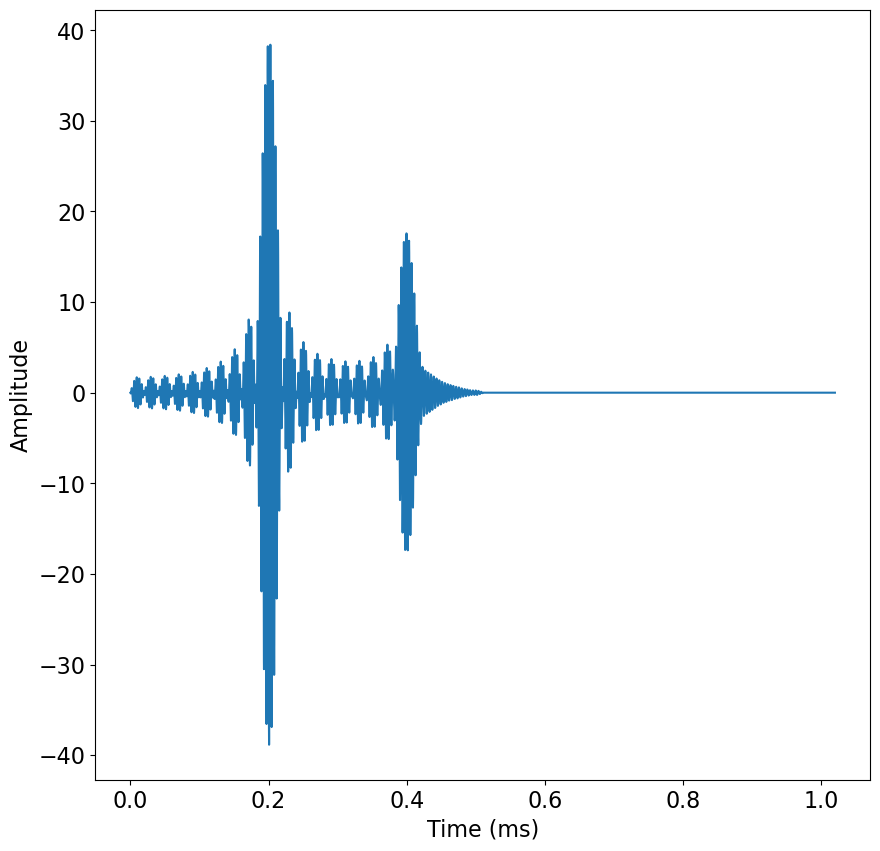

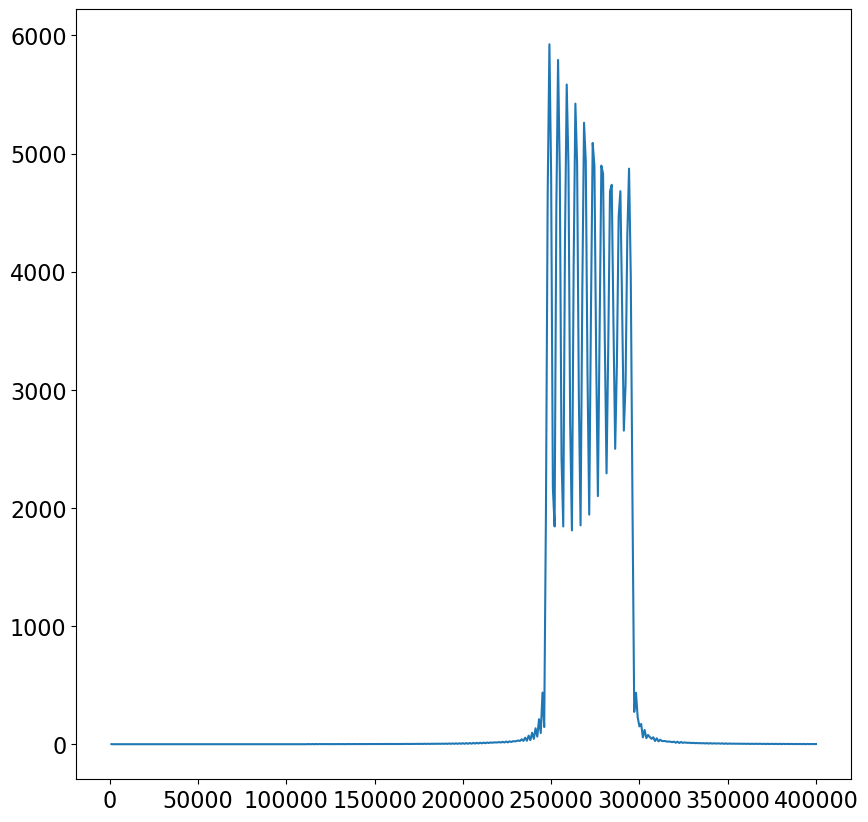

In [122]:
def wavelet(time_values, packet_l, f0, a = 2):
    t0 = 1/f0
    t = time_values[np.newaxis, :] - t0[:, np.newaxis]
    r = (np.pi *  f0[:, np.newaxis] *t)
    wave = a * np.sin(r) + a*np.sin((packet_l-1)*(r+np.pi)/packet_l)
    #print(wave.shape)
    for fidx, f in enumerate(f0):
        wave[fidx, np.searchsorted(time_values, packet_l*2/f0[fidx]):] = 0
    return wave

time_values = np.arange(t0, tn, dt)

fd = 10
fn = 10

f = np.arange(0, fn*fd, fd) + f0

wave = np.sum(wavelet(time_values, 128, f), axis=0)

plt.plot(time_values, wave)
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.tick_params()
plt.show()


yf = fft(wave)
xf = fftfreq(len(time_values), dt*1e-3)

on = list(map(lambda x: x > 0 and x < 400e3, xf))

plt.plot(xf[on], np.abs(yf[on]))
plt.show()
